In [1]:
from dataloader import load_samples_dataset, quanti_cols_df_names, quali_cols_df_names
from samples_dataset import SamplesDataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math
import shap
import pandas as pd

%matplotlib widget
from matplotlib import pyplot as plt

threshold = 0.5

# Train function

In [2]:
def train(model, dataloader, optimizer, criterion, n_epoch=10, verbose=False):
    device = next(model.parameters()).device
    mean_loss = []
    nb_examples = len(dataloader.dataset)

    model.train(True)
    pbar = tqdm(range(n_epoch), bar_format='{percentage:3.0f}%{bar}{n_fmt}/{total_fmt} epoch(s) [{elapsed}<{remaining}, {rate_fmt}{postfix}]')
    for epoch in pbar:  # loop over the dataset multiple times
        loss_sum = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)[:,0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
        mean_loss.append(loss_sum / nb_examples)

    if verbose:
        print('Finished Training')
        plt.title('Mean error for each epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Mean error')
        plt.plot(range(1, n_epoch + 1), mean_loss)

# Test function

In [3]:
def test_with_dataloader(model, dataloader, verbose=False):
    device = next(model.parameters()).device

    model.eval()    
    with torch.no_grad():
        accuracy = 0.0
        nb_examples = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            nb_examples += len(inputs)

            outputs = model(inputs)[:,0]
            outputs = (outputs >= threshold).float()
            accuracy += torch.sum(outputs == labels).item()

        accuracy /= nb_examples
        return accuracy * 100

def test_X_y(model, X, y, verbose=False):
    samples_test = SamplesDataset()
    samples_test.add_examples(X, y)
    dataloader = DataLoader(samples_test, batch_size=64, shuffle=True, pin_memory=True)
    
    return test_with_dataloader(model, dataloader, verbose)

# Predict function

In [4]:
def predict(model, X):
    device = next(model.parameters()).device
    X = torch.Tensor(torch.Tensor(X))
    X = X.to(device)

    model.eval()
    results = model(X)
    results = (results >= threshold).cpu().float().numpy()
    return torch.from_numpy(results).T[0]

# Cross-validation function

In [5]:
def cross_valisation(model, X, y, optimizer, criterion, k=10, n_epoch=50):
    accuracies = list()

    if len(X) != len(y):
            raise Exception(f'The size of X {len(X)} must be the same as the size y {len(y)}.')
    
    dataset_X_folds = np.array_split(X, k)
    dataset_y_folds = np.array_split(y, k)

    print(f'Starting {k}-fold cross-validation.')
    pbar = tqdm(range(k), bar_format='Cross-validation performed at {percentage:3.0f}%{bar}{r_bar}')
    for i in pbar:
        samples_train = SamplesDataset()
        dataset_X_train = np.concatenate(dataset_X_folds[0:i] + dataset_X_folds[i+1: len(dataset_X_folds)])
        dataset_y_train = np.concatenate(dataset_y_folds[0:i] + dataset_y_folds[i+1: len(dataset_y_folds)])
        samples_train.add_examples(dataset_X_train, dataset_y_train)

        samples_test = SamplesDataset()
        dataset_X_test = dataset_X_folds[i]
        dataset_y_test = dataset_y_folds[i]
        samples_test.add_examples(dataset_X_test, dataset_y_test)

        train_dataloader = DataLoader(samples_train, batch_size=64, shuffle=True, pin_memory=True)
        test_dataloader = DataLoader(samples_test, batch_size=64, shuffle=True, pin_memory=True)

        train(model=model, dataloader=train_dataloader, optimizer=optimizer, criterion=criterion, n_epoch=n_epoch)
        accuracy = test_with_dataloader(model=model, dataloader=test_dataloader)

        accuracies.append(accuracy)

    return np.array(accuracies)

# Main

## Loading data

In [6]:
full_dataset = load_samples_dataset(from_csv=False)
X, y = full_dataset.get_row_dataset()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

print(f'Training examples count : {len(X_train)}.')
print(f'Testing examples count : {len(X_test)}.')

Samples shape : (1861, 115).

Cleaning samples columns : 77 columns dropped.
Samples shape after clean and dummy variables : (1861, 66).

Creating positive examples.
-> 649 different ids.


  0%|          | 0/649 [00:00<?, ?it/s]

Creating negative examples.


  0%|          | 0/7326 [00:00<?, ?it/s]

Dataset size : 21978
Training examples count : 15384.
Testing examples count : 6594.


Matrix shape : (15384, 130).


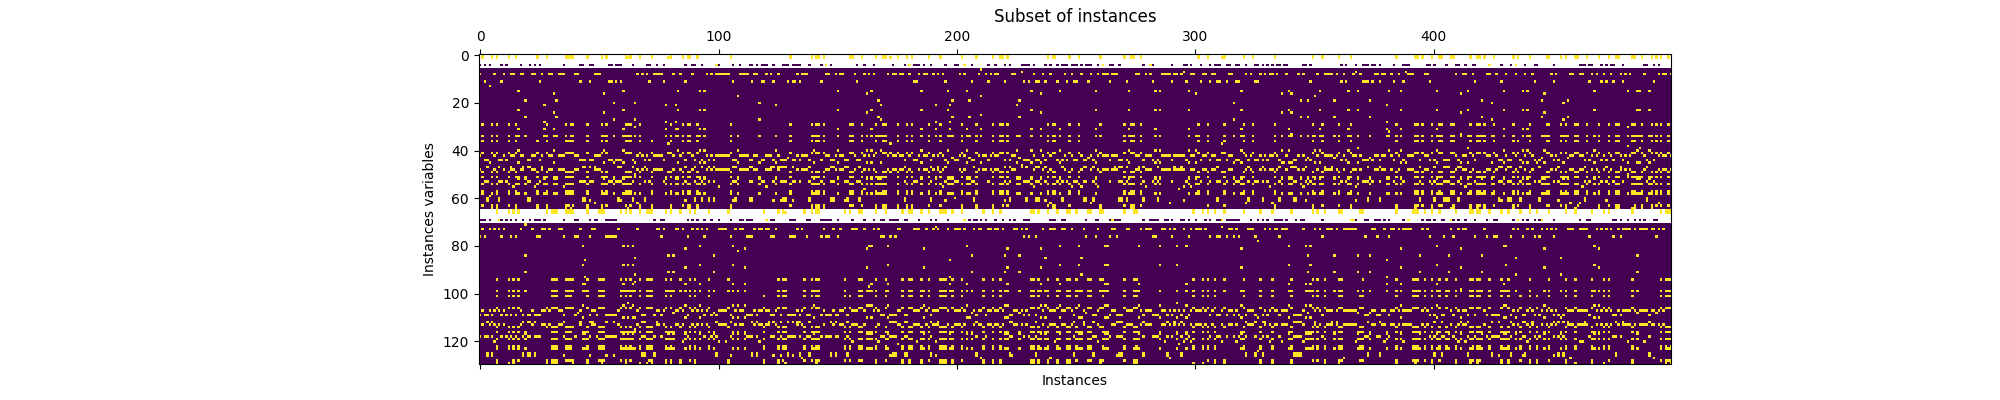

Matrix is 82.70% sparse


In [7]:
matrix = np.matrix(X_train)
matrix = matrix
print(f'Matrix shape : {matrix.shape}.')

bin_matrix = matrix.copy()
bin_matrix[bin_matrix > 0] = 1

plot_matrix = bin_matrix[:500,:].T

matfig = plt.figure(figsize=(20,4))
plt.matshow(plot_matrix, fignum=matfig.number)
plt.title('Subset of instances')
plt.xlabel('Instances')
plt.ylabel('Instances variables')
plt.show()

sparsisty = np.count_nonzero(matrix == 0) / matrix.size
print(f'Matrix is {100 * sparsisty:3.2f}% sparse')

## Creating model

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

n_input = len(X_train[0])
n_hidden_1 = math.floor(n_input / 3)
model = nn.Sequential(
    nn.Linear(n_input, n_hidden_1),
    nn.ReLU(),
    nn.Linear(n_hidden_1, 1),
    nn.ReLU(),
    nn.Sigmoid()
)
model = model.float()

model.to(device)

print(f'Model: {model}')
print(f'Model on device : {next(model.parameters()).device}.')

criterion = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Model: Sequential(
  (0): Linear(in_features=130, out_features=43, bias=True)
  (1): ReLU()
  (2): Linear(in_features=43, out_features=1, bias=True)
  (3): ReLU()
  (4): Sigmoid()
)
Model on device : cuda:0.


## Perfoming cross-validation

Starting 7-fold cross-validation.


Cross-validation performed at   0%          | 0/7 [00:00<?, ?it/s]

  0%          0/20 epoch(s) [00:00<?, ?it/s]

  0%          0/20 epoch(s) [00:00<?, ?it/s]

  0%          0/20 epoch(s) [00:00<?, ?it/s]

  0%          0/20 epoch(s) [00:00<?, ?it/s]

  0%          0/20 epoch(s) [00:00<?, ?it/s]

  0%          0/20 epoch(s) [00:00<?, ?it/s]

  0%          0/20 epoch(s) [00:00<?, ?it/s]

Accuracy mean : 66.28303156857895
Accuracy standard deviation : 1.0698468201715532


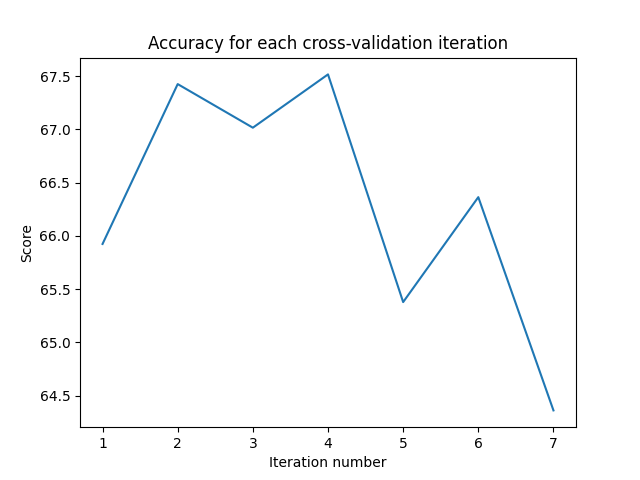

In [9]:
k = 7
accuracies = cross_valisation(model=model, X=X_train, y=y_train, optimizer=optimizer, criterion=criterion, k=k, n_epoch=20)
print(f'Accuracy mean : {accuracies.mean()}')
print(f'Accuracy standard deviation : {accuracies.std()}')

plt.figure()
plt.title('Accuracy for each cross-validation iteration')
plt.xlabel('Iteration number')
plt.ylabel('Score')
plt.plot(range(1, k + 1), accuracies)

Test acuracy : 67.56%.


Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)


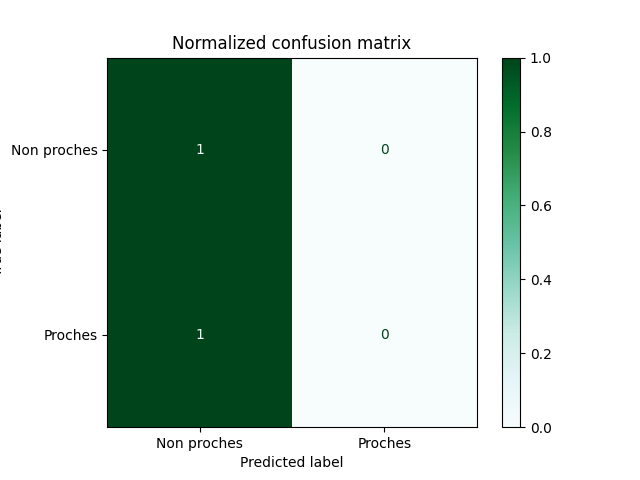

In [10]:
y_pred = predict(model=model, X=X_test)
y_test_tensor = torch.Tensor([y_test])[0]

# Accuracy
pred_accuracy = torch.sum(y_pred == y_test_tensor).item() / len(y_test) * 100
print(f'Test acuracy : {pred_accuracy:0.2f}%.')

# Confusion matrix
display = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize='true',
    display_labels=np.asarray(['Non proches', 'Proches']),
    cmap=plt.cm.BuGn)
display.ax_.set_title('Normalized confusion matrix')

plt.show()

In [11]:
model_wrap = lambda data : model(torch.from_numpy(data))
X_test_tensor = torch.Tensor(torch.Tensor(X_test)).to(device)

explainer = shap.DeepExplainer(model=model, data=X_test_tensor)
shap_val = explainer.shap_values(X_test_tensor[:1])

AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: nan - Tolerance: 0.01

In [ ]:
feature_names = full_dataset.get_columns_names()

shap_values_df = pd.DataFrame(shap_val, columns = full_dataset.get_columns_names())

plt.figure()
plt.title('Shapley values')
shap.summary_plot(shap_val, features=shap_values_df)